# Installazione e Import (Setup)

In [1]:
%pip install numpy scipy matplotlib

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

print("Librerie caricate correttamente.")


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Librerie caricate correttamente.


# Funzioni di Utilità

In [2]:
def poly_mul(p1, p2):
    return np.convolve(p1, p2)

def poly_add(p1, p2):
    return np.polyadd(p1, p2)

def poly_sub(p1, p2):
    return np.polysub(p1, p2)

def roots_to_poly(roots):
    if len(roots) == 0: return np.array([1.0])
    return np.poly(roots)

def format_poly_string(coeffs):
    coeffs = np.where(np.abs(coeffs) < 1e-5, 0, coeffs)
    if np.all(coeffs == 0): return "0"

    terms = []
    degree = len(coeffs) - 1
    first_term = True
    
    for i, c in enumerate(coeffs):
        power = degree - i
        if c == 0: continue
        if first_term:
            sign = "" if c > 0 else "-"
            first_term = False
        else:
            sign = " + " if c > 0 else " - "
        
        abs_c = abs(c)
        val_str = f"{abs_c:.4f}"
        if power == 0: z_str = ""
        elif power == 1: z_str = "z"
        else: z_str = f"z^{power}"
            
        terms.append(f"{sign}{val_str}{z_str}")
        
    return "".join(terms)

def print_result(name, num, den):
    num_str = format_poly_string(num)
    den_str = format_poly_string(den)
    width = max(len(num_str), len(den_str))
    padding = 4
    line = "-" * width
    
    print(f"\n{name} =")
    print(f"{' ' * padding}{num_str.center(width)}")
    print(f"{' ' * padding}{line}")
    print(f"{' ' * padding}{den_str.center(width)}")

# Calcolo Impianto Discreto

In [3]:
def get_discrete_sys_case1(a, T, K):
    if a == 0: return [K*T], [1, -1]
    alpha = np.exp(-a*T)
    return [(K/a)*(1-alpha)], [1, -alpha]

def get_discrete_sys_case2(a, T, K):
    alpha = np.exp(-a*T)
    lam = (K/(a**2)) * (a*T - 1 + alpha)
    beta = (K/(a**2)) * (1 - alpha - a*T*alpha)
    return [lam, beta], [1, -(1+alpha), alpha]

def get_discrete_sys_case3(a, b, T, K):
    alpha = np.exp(-a*T)
    common = (a - b) * (1 - alpha)
    lam = (K/(a**2)) * (common + b*a*T)
    beta = -(K/(a**2)) * (common + b*a*T*alpha)
    return [lam, beta], [1, -(1+alpha), alpha]

def get_Pd_from_input(case, a, b, K, T):
    if case == 1:   return get_discrete_sys_case1(a, T, K)
    elif case == 2: return get_discrete_sys_case2(a, T, K)
    elif case == 3: return get_discrete_sys_case3(a, b, T, K)
    else: return [0], [1]

# Sintesi Controllore

In [4]:
def calculate_stabilizing_controllers(num_P, den_P, T):
    poles = np.roots(den_P)
    unstable_indices = np.where(np.abs(poles) >= 1.0 - 1e-5)[0]
    
    if len(unstable_indices) == 0:
        return ([0.0], [1.0]), ([1.0], [1.0]), ([1.0], [1.0]), (num_P, den_P), True

    else:
        zeros = np.roots(num_P)
        p_unst = poles[np.abs(poles) >= 1.0 - 1e-5]
        p_stab = poles[np.abs(poles) < 1.0 - 1e-5]
        z_unst = zeros[np.abs(zeros) >= 1.0 - 1e-5]
        z_stab = zeros[np.abs(zeros) < 1.0 - 1e-5]

        A_plus = roots_to_poly(p_unst)
        A_minus = roots_to_poly(p_stab)
        B_plus = roots_to_poly(z_unst)
        B_minus_monic = roots_to_poly(z_stab)

        reconstructed = poly_mul(B_plus, B_minus_monic)
        idx = next((i for i, x in enumerate(num_P) if abs(x) > 1e-10), 0)
        k_gain = num_P[idx] / reconstructed[0] if len(reconstructed)>0 else 1.0
        B_minus = k_gain * B_minus_monic

        nP = len(p_unst)
        nZ = len(z_unst)
        E = max(1, (len(den_P)-1) - (len(num_P)-1))
        deg_den_W = nP + nZ + E - 1

        # Calcolo F(z)
        if nP == 1:     
            p = p_unst[0]
            b_val = np.polyval(B_plus, p)
            f0 = (p ** deg_den_W) / b_val
            F_poly = np.array([f0])
        else:
            M_matrix = []
            b_vector = []
            for p in p_unst:
                rhs = (p ** deg_den_W) / np.polyval(B_plus, p)
                b_vector.append(rhs)
                row = [p**k for k in range(nP)]
                M_matrix.append(row)
            try:
                F_poly = np.linalg.solve(M_matrix, b_vector)[::-1]
            except:
                F_poly = np.linalg.lstsq(M_matrix, b_vector, rcond=None)[0][::-1]

        # Calcolo W(z) e H(z)
        W_num = poly_mul(B_plus, F_poly)
        z_pow_W = np.zeros(deg_den_W + 1); z_pow_W[0] = 1.0
        
        diff_poly = poly_sub(z_pow_W, W_num)
        H_num, remainder = signal.deconvolve(diff_poly, A_plus)
        
        if np.max(np.abs(remainder)) > 1e-4:
            print(f"[WARN] Resto divisione H(z) non nullo: {np.max(np.abs(remainder))}")

        z_pow_nP = np.zeros(nP + 1); z_pow_nP[0] = 1.0
        deg_XY = nZ + E - 1
        z_pow_XY = np.zeros(deg_XY + 1); z_pow_XY[0] = 1.0
        
        M = (A_plus, z_pow_nP)
        N = (poly_mul(B_plus, B_minus), poly_mul(A_minus, z_pow_nP))
        X = (poly_mul(A_minus, F_poly), poly_mul(B_minus, z_pow_XY))
        Y = (H_num, z_pow_XY)

        return X, Y, M, N, False

def compute_Cd_generic(X, Y, M, N, Q, is_stable):
    Qn, Qd = Q
    if is_stable:
        Pn, Pd = N
        num_final = poly_mul(Qn, Pd)
        den_final = poly_sub(poly_mul(Qd, Pd), poly_mul(Pn, Qn))
    else:
        Xn, Xd = X; Yn, Yd = Y
        Mn, Md = M; Nn, Nd = N
        
        num_top = poly_add(poly_mul(Xn, poly_mul(Md, Qd)), poly_mul(Mn, poly_mul(Qn, Xd)))
        den_top = poly_mul(Xd, poly_mul(Md, Qd))
        num_bot = poly_sub(poly_mul(Yn, poly_mul(Nd, Qd)), poly_mul(Nn, poly_mul(Qn, Yd)))
        den_bot = poly_mul(Yd, poly_mul(Nd, Qd))
        
        num_final = poly_mul(num_top, den_bot)
        den_final = poly_mul(den_top, num_bot)

    return num_final, den_final

# Main

In [5]:
# Setup Parametri
CASE = 3
a_val = -1.0 
b_val = 2.0
T_val = 0.1
K_val = 1.0

print(f"--- Configurazione Caso {CASE} ---")
print(f"a = {a_val}, b = {b_val}, T = {T_val}, K = {K_val}")

# 2. Ottieni Pd(z)
pd_num, pd_den = get_Pd_from_input(CASE, a_val, b_val, K_val, T_val)
print_result("Impianto Pd(z)", pd_num, pd_den)

# 3. Ottini X, Y, M, N per Cd(z)
X, Y, M, N, is_stable = calculate_stabilizing_controllers(pd_num, pd_den, T_val)

# 4. Scegli Q(z)
Q = ([5.0], [1.0])

# 5. Calcola Cd(z)
cd_num, cd_den = compute_Cd_generic(X, Y, M, N, Q, is_stable)

# 6. Output Finale
print_result("Controllore Stabilizzante Cd(z)", cd_num, cd_den)

--- Configurazione Caso 3 ---
a = -1.0, b = 2.0, T = 0.1, K = 1.0

Impianto Pd(z) =
          0.1155z - 0.0945      
    ----------------------------
    1.0000z^2 - 2.1052z + 1.1052

Controllore Stabilizzante Cd(z) =
    2.6827z^5 - 2.7934z^4 + 1.6328z^3 - 0.5221z^2
    ---------------------------------------------
    0.1155z^5 - 0.1612z^4 + 0.1091z^3 - 0.0446z^2


# Confronto Prestazioni: Gamma vs Sintesi Wd(z)=1/z

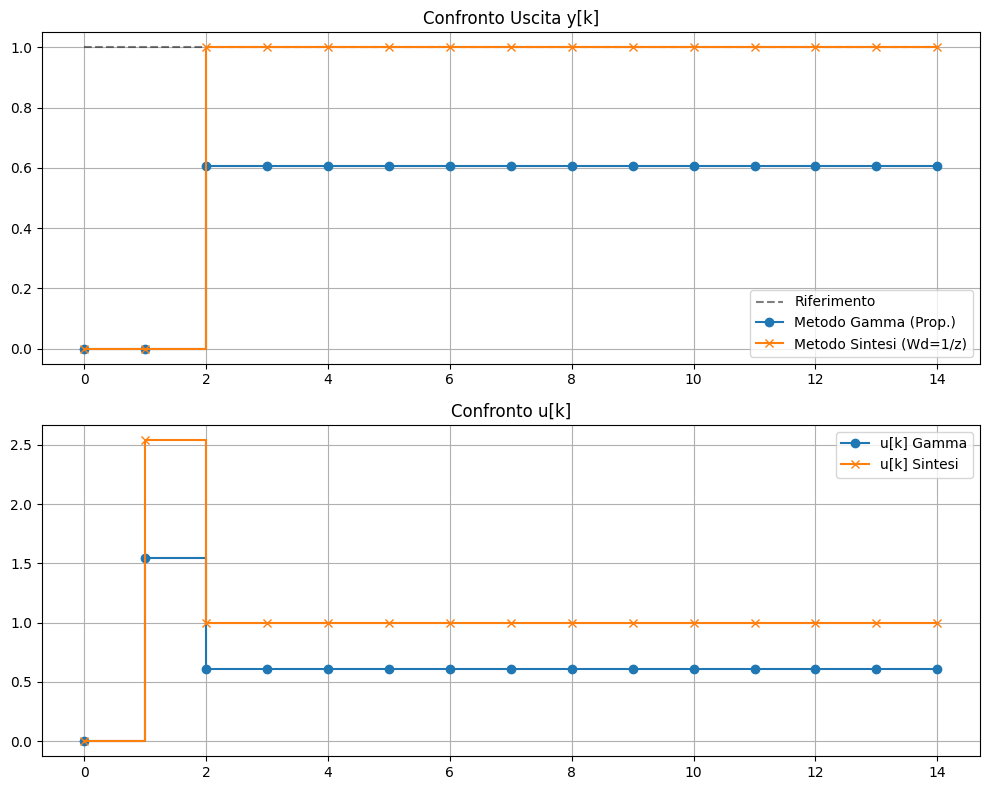

In [6]:
# @title 6. Confronto Prestazioni: Gamma vs Sintesi Wd(z)=1/z

# P(s) = 1 / (s+1) -> Pd(z) = beta / (z - alpha)
a = 1.0
T = 0.5
alpha = np.exp(-a*T)       
beta = (1.0/a)*(1-alpha) 

# METODO 1: Gamma
gamma = alpha / beta 

# METODO 2: Sintesi Wd(z) = 1/z
# u[k] = u[k-1] + (1/beta)*e[k] - (alpha/beta)*e[k-1]
coeff_e_k = 1.0 / beta
coeff_e_k1 = -alpha / beta


steps = 15
t = np.arange(steps)
r = np.ones(steps) 

# Metodo Gamma
y_g = np.zeros(steps)
u_g = np.zeros(steps) 
e_g = np.zeros(steps)

# Metodo Sintesi
y_s = np.zeros(steps)
u_s = np.zeros(steps)
e_s = np.zeros(steps)

# Simulazione
for k in range(1, steps):

    # y[k] = alpha * y[k-1] + beta * u[k-1] uguale per entrambi
    y_g[k] = alpha * y_g[k-1] + beta * u_g[k-1]
    y_s[k] = alpha * y_s[k-1] + beta * u_s[k-1]
    
    # Calcolo errori
    e_g[k] = r[k] - y_g[k]
    e_s[k] = r[k] - y_s[k]
    
    # Calcolo di u_k gamma
    # u[k] = gamma * e[k]
    u_g[k] = gamma * e_g[k]
    
    # Calcolo di u_k sintesi
    # u[k] = u[k-1] + (1/beta)*e[k] - (alpha/beta)*e[k-1]
    u_s[k] = u_s[k-1] + (coeff_e_k * e_s[k]) + (coeff_e_k1 * e_s[k-1])

# Grafici
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Confronto Uscite
axs[0].step(t, r, 'k--', label='Riferimento', alpha=0.5)
axs[0].step(t, y_g, 'o-', label=f'Metodo Gamma (Prop.)', where='post')
axs[0].step(t, y_s, 'x-', label='Metodo Sintesi (Wd=1/z)', where='post')
axs[0].set_title('Confronto Uscita y[k]')
axs[0].legend()
axs[0].grid(True)

# Confronto Ingressi di Controllo
axs[1].step(t, u_g, 'o-', label='u[k] Gamma', where='post')
axs[1].step(t, u_s, 'x-', label='u[k] Sintesi', where='post')
axs[1].set_title('Confronto u[k]')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Verifica Comportamento Continuo con Dead Beat

/Users/davidemeta/Documents/Università/Tesi/python_files/sample_data_systems/venv/lib/python3.13/site-packages/scipy/signal/_ltisys.py:603: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


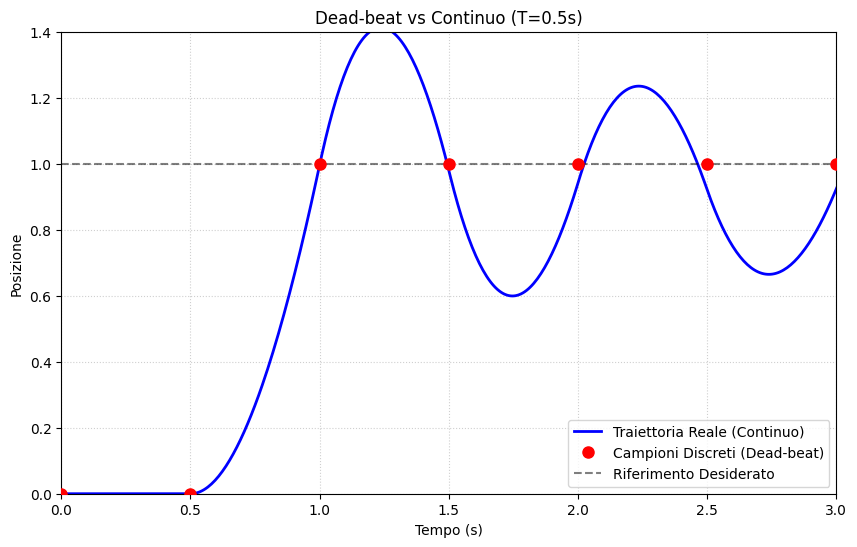

In [7]:
# Parametri
K = 1.0
a = 1.0
T = 0.5 

# Sistema Continuo: P(s) = 1 / s(s+1)
sys_continuous = signal.TransferFunction([K], [1, a, 0])
sys_discrete = sys_continuous.to_discrete(dt=T, method='zoh')
num_d = sys_discrete.num
den_d = sys_discrete.den

steps = 15
t_discrete = np.arange(steps) * T
r_k = np.ones(steps) 

y_target = np.zeros(steps)
y_target[2:] = 1.0 

num_d_stripped = num_d[1:] if num_d[0] == 0 else num_d

# Spostiamo y_target a sinistra di 1 (per compensare lo zero tolto)
y_target_shifted = np.roll(y_target, -1)
y_target_shifted[-1] = 1.0

u_k = signal.lfilter(den_d, num_d_stripped, y_target_shifted)

# Segnale continuo
resolution = 1000
t_continuous = np.linspace(0, (steps-1)*T, resolution)

# u(t) continuo 
indices = (t_continuous / T).astype(int)
indices = np.clip(indices, 0, len(u_k)-1)
u_continuous_signal = u_k[indices]

sys_ss = signal.lti(sys_continuous.num, sys_continuous.den).to_ss()
_, y_continuous, _ = signal.lsim(sys_ss, U=u_continuous_signal, T=t_continuous)

# Grafici
plt.figure(figsize=(10, 6))

plt.plot(t_continuous, y_continuous, 'b-', label='Traiettoria Reale (Continuo)', linewidth=2)
plt.plot(t_discrete, y_target, 'ro', label='Campioni Discreti (Dead-beat)', markersize=8, zorder=5)
plt.plot(t_discrete, r_k, 'k--', label='Riferimento Desiderato', alpha=0.5)

plt.title(f'Dead-beat vs Continuo (T={T}s)')
plt.xlabel('Tempo (s)')
plt.ylabel('Posizione')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.xlim(0, 3.0) 
plt.ylim(0, 1.4)

plt.show()